# Imports and define functions

In [17]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.gridspec as gridspec

from collections import OrderedDict
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, bds
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Define Mean Absolute Percentage Error
def printMAEpred(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    ape = 100*(abs(y_pred - y_true.T) / y_true.T);
    for i in horizonSteps:
        print('Prediction for ' + str(i) + ' step: MAE = ' + str(round(np.mean(ae[0,:i]), 2)) + ' (' + str(round(np.mean(ape[0,:i]), 2)) + '%)'  )

In [8]:
# Evaluate combinations of p, d and q values for an ARIMA model
def ARIMA_grid(dataset, arimaCfg, isLog):
    df_IC = pd.DataFrame( columns=['ARIMA(p,d,q)', 'AIC', 'BIC', 'HQIC'])
    df_IC = df_IC.set_index('ARIMA(p,d,q)')
    dict_arimaFit  = {} 
    dict_arimaPred = {} 
    modelNum = 0;
    totalModelNum = len(arimaCfg.p_range)*len(arimaCfg.d_range)*len(arimaCfg.q_range)
    for p in arimaCfg.p_range:
        for d in arimaCfg.d_range:
            for q in arimaCfg.q_range:
                order = (p,d,q)
                modelNum+=1;
                print("%d/%d " % (modelNum, totalModelNum))
                try:
                    model = ARIMA(dataset, order=order);
                    model_fit = model.fit(disp=0);

                    model_str = 'ARIMA' + str(order)
                    df_IC = df_IC.append(pd.DataFrame({'AIC':model_fit.aic, 'BIC':model_fit.bic, \
                                                       'HQIC':model_fit.hqic}, index =[model_str]), ignore_index=False)
                    
                    if (isLog):
                        dict_arimaFit[model_str]  = np.e**(model_fit.predict(typ='levels'));
                        dict_arimaPred[model_str] = np.e**(model_fit.forecast(steps=stepsToForecast[-1])[0]);
                    else:
                        dict_arimaFit[model_str]  = model_fit.predict(typ='levels');
                        dict_arimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1])[0];
                except:
                    continue
    return dict_arimaFit, dict_arimaPred, df_IC

## Import Data

In [34]:
# df = Dataframe with an index and a value column
# title = Title of data being used
# xlab = Label of df.index
# ylab = Label of df.values
# seasonal_periods = The repetition cycle

previousStepsToShow = 15;

#stepsToForecast = [1, 3, 12]
#df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
#df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
#df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
#title = 'CPIAUC'
#xlab = 'Months/Year'; 
#ylab = 'CPI: Index 1982-1984=100 (Seasonally Adjusted)';
#seasonal_periods = 12

#stepsToForecast = [1, 5, 21]
#df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
#df = pd.DataFrame(df, columns= ['Date','Close'])
#df.set_index('Date', drop=True, inplace=True)
#df.index = pd.to_datetime(df.index)
#df = df.truncate(before='2002-01-01', after='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'PSI20: Historical Closing Prices'
#xlab = 'Working Days/Year'; 
#ylab = 'Closing Price (Euro)';
#seasonal_periods = 5

stepsToForecast = [1, 5, 21]
df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
title = 'SP500'
xlab = 'Days/Year'; 
ylab = 'Closing Price ($)';
seasonal_periods=5;

# Assess Stationarity of the Time-Series

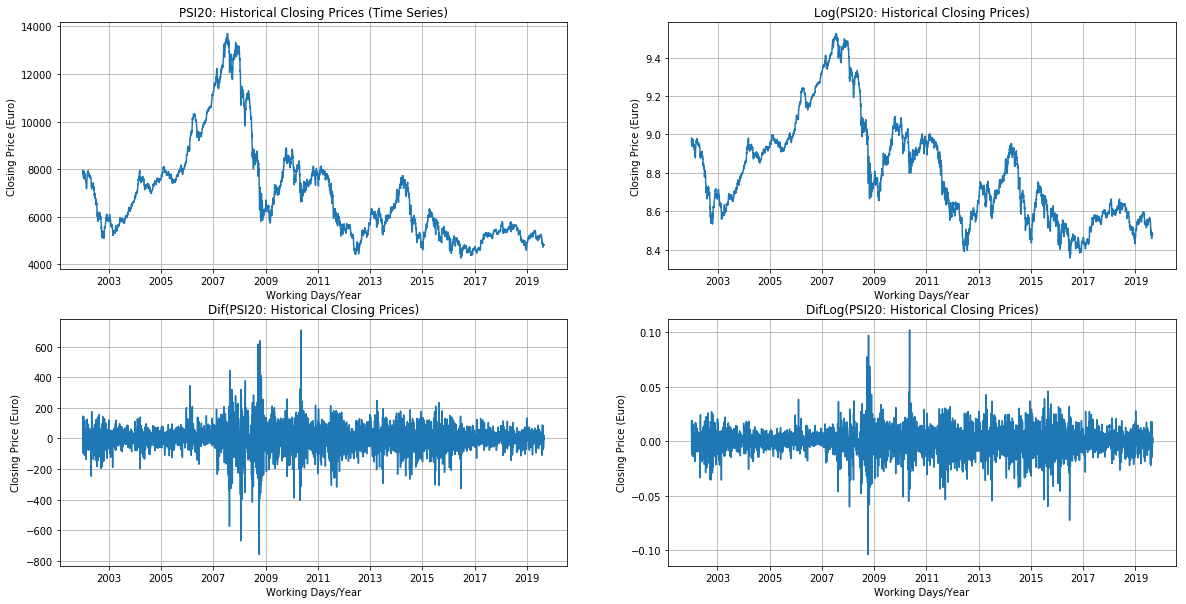

In [5]:
# In order to achieve stationarity, it is common to use Log transformations
# Transformations such as logarithms can help to stabilise the variance of a time series. 
# Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, 
#and therefore eliminating (or reducing) trend and seasonality.
fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
plt.title(title + ' (Time Series)')
plt.plot(df_train)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(222)
plt.title('Log(' + title + ')')
plt.plot(np.log(df_train))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(223)
plt.title('Dif(' + title + ')')
plt.plot(df_train.diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(224)
plt.title('DifLog(' + title + ')')
plt.plot(np.log(df_train).diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

plt.show()

In [6]:
# Jarque-Bera goodness of fit test on sample data
# Tests if the sample data has the skewness and kurtosis matching a normal distribution
jb, jbpval = stats.jarque_bera(df_train)
print("Jarque-Bera Test for " + title)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train))
print("Jarque-Bera Test for Log(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(df_train.diff().dropna())
print("Jarque-Bera Test for Diff(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train).diff().dropna())
print("Jarque-Bera Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval) 
print("")

Jarque-Bera Test for PSI20: Historical Closing Prices
Statistic: 1523.8499
p-value: 0.0000

Jarque-Bera Test for Log(PSI20: Historical Closing Prices)
Statistic: 401.2853
p-value: 0.0000

Jarque-Bera Test for Diff(PSI20: Historical Closing Prices)
Statistic: 15300.0166
p-value: 0.0000

Jarque-Bera Test for Diff(Log(PSI20: Historical Closing Prices))
Statistic: 8910.3486
p-value: 0.0000



In [7]:
# Kolmogorov-Smirnov Test goodness of fit test on sample data
ks, kspval = stats.kstest(df_train.values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  
print("")
ks, kspval = stats.kstest(np.log(df_train), 'norm')
print("Kolmogorov-Smirnov Test for Log(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(df_train.diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(np.log(df_train).diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 
print("")

Kolmogorov-Smirnov Test
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Log(PSI20: Historical Closing Prices)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(PSI20: Historical Closing Prices)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Log(PSI20: Historical Closing Prices))
Statistic: 0.5413
p-value: 0.0000



In [8]:
# The Augmented Dickey-Fuller test 
# Used to test for a unit root in a univariate process in the presence of serial correlation.
result = adfuller(df_train['train'].values, regression='c')
print("Augmented Dickey Fuller Test for " + title)
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train'].values), regression='c')
print("Augmented Dickey Fuller Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(df_train['train'].diff().dropna(), regression='c')
print("Augmented Dickey Fuller Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print ("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train']).diff().dropna().values, regression='c')
print("Augmented Dickey Fuller Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey Fuller Test for PSI20: Historical Closing Prices
Statistic: -1.4390
p-value: 0.5634
Used lags: 17
Num obs: 4495
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Log(PSI20: Historical Closing Prices)
Statistic: -1.3946
p-value: 0.5849
Used lags: 16
Num obs: 4496
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Diff(PSI20: Historical Closing Prices)
Statistic: -14.4348
p-value: 0.0000
Used lags: 16
Num obs: 4495
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Diff(Log(PSI20: Historical Closing Prices))
Statistic: -15.8199
p-value: 0.0000
Used lags: 15
Num obs: 4496
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [9]:
# Kwiatkowski-Phillips-Schmidt-Shin
# Test for level or trend stationarity
result = kpss(df_train['train'].values, regression='c')
print("KPSS Test for " + title)
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train'].values), regression='c')
print("KPSS Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(df_train['train'].diff().dropna(), regression='c')
print("KPSS Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train']).diff().dropna().values, regression='c')
print("KPSS Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

KPSS Test for PSI20: Historical Closing Prices
Statistic: 5.4021
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Log(PSI20: Historical Closing Prices)
Statistic: 6.2870
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(PSI20: Historical Closing Prices)
Statistic: 0.0939
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(Log(PSI20: Historical Closing Prices))
Statistic: 0.0797
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


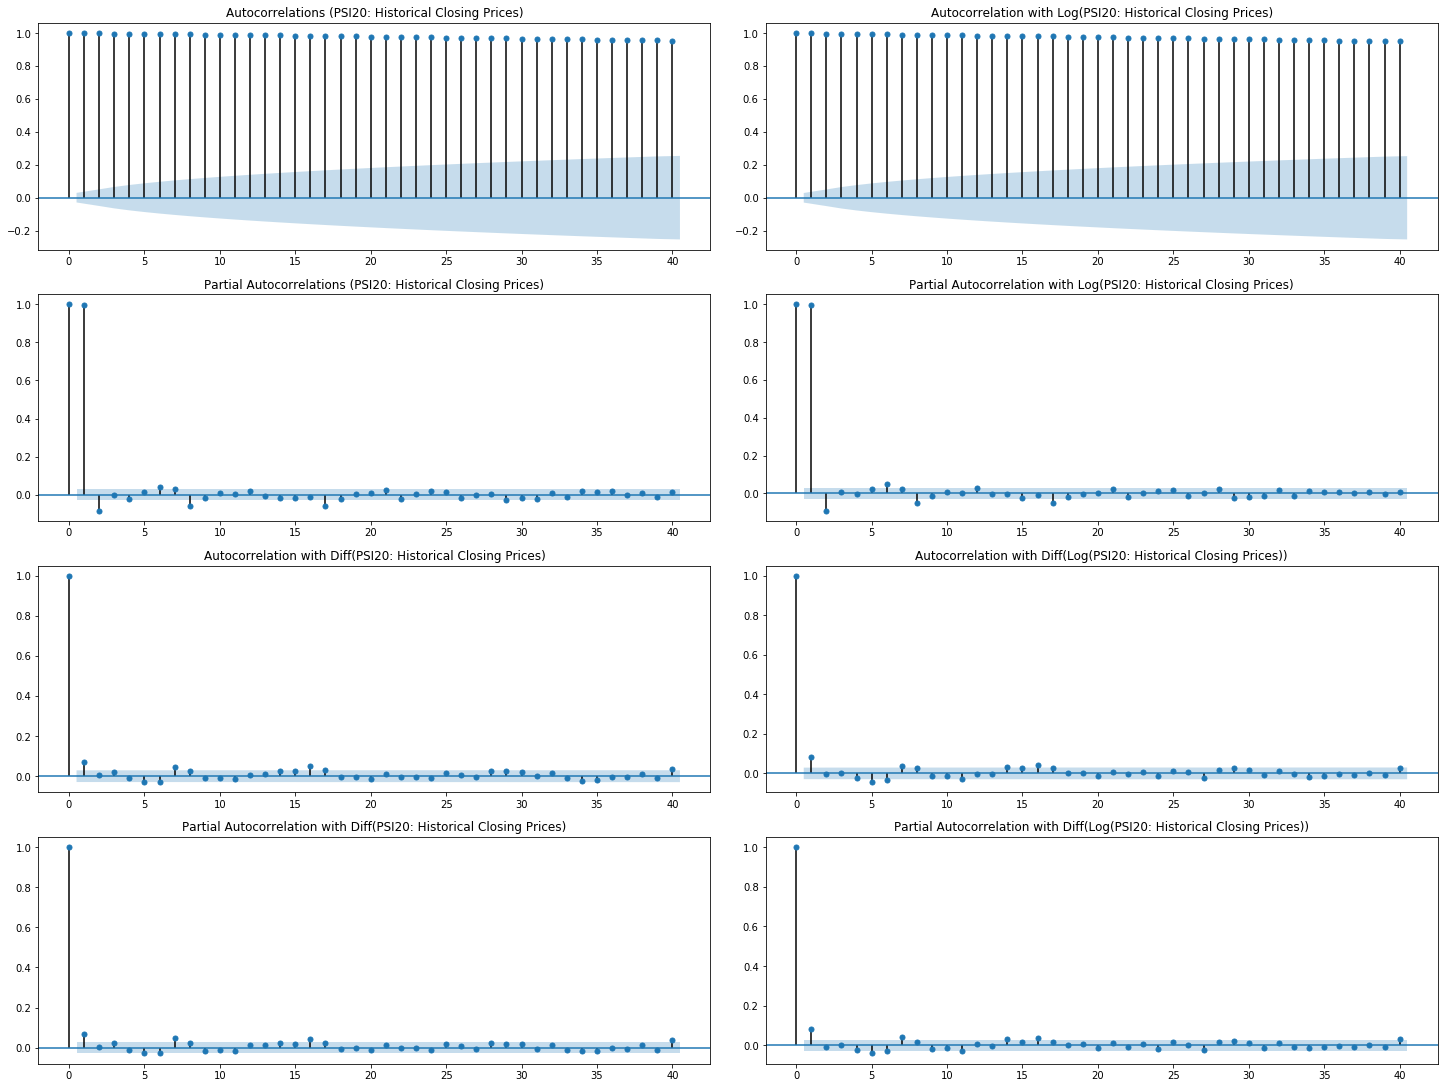

In [10]:
# Correlation plots
# These plots are useful for identifying non-stationary time series 

# This also gives an idea of the order of the model by:
# AR(p) - p from the partial autocorrelation plot
# I(d)  - d from the number of Diffs your dataset is using
# MA(q) - q from the autocorrelation plot

maxLags = 40

fig = plt.figure(figsize=(20,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_train, lags=maxLags, ax=ax_acf, title='Autocorrelations (' + title + ')')
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_train, lags=maxLags, ax=ax_pacf, title='Partial Autocorrelations (' + title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfLog = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(np.log(df_train), lags=maxLags, ax=ax_acfLog, title='Autocorrelation with Log('+ title + ')')
# Partial auto-correlation function for time series transformed with Log
ax_pacfLog = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train), lags=maxLags, ax=ax_pacfLog, title='Partial Autocorrelation with Log('+ title + ')');

# Auto-correlation function for time series transformed with Diff
ax_acfDiff = fig.add_subplot(spec[2, 0])
sm.graphics.tsa.plot_acf(df_train.diff().dropna(), lags=maxLags, ax=ax_acfDiff, title='Autocorrelation with Diff('+ title + ')')
# Partial auto-correlation function for time series transformed with Diff
ax_pacfDiff = fig.add_subplot(spec[3, 0])
sm.graphics.tsa.plot_pacf(df_train.diff().dropna(), lags=maxLags, ax=ax_pacfDiff, title='Partial Autocorrelation with Diff('+ title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfDiffLog = fig.add_subplot(spec[2, 1])
sm.graphics.tsa.plot_acf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_acfDiffLog, title='Autocorrelation with Diff(Log('+ title + '))')
# Partial auto-correlation function for time series transformed with Log
ax_pacfDiffLog = fig.add_subplot(spec[3, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_pacfDiffLog, title='Partial Autocorrelation with Diff(Log('+ title + '))');

In [35]:
# From now on, we must choose whether we go with the Log(Time-Series) or not
# This should be done to remove stationarity of the data, so that ARIMA works
# In addition, if the model is multiplicative we need to use log to make it additive
#as ARIMA relies on that assumption

# The previously seen differentiated data enters in the I component of the ARIMA model
#it will take care of differenciating for us

#df_Train = df_train
#isLog = False

#df_Train = pd.DataFrame(np.log(df_train), index = df_train.index)
#isLog = True
isLog = False
df_Train = df_train

## Run different ARIMA models combinations

In [12]:
# Range of ARIMA models to compute
class arimaCfg:
    p_range = range(4, 5) # [1,7)
    d_range = range(1, 3) # [1,3)
    q_range = range(3, 6) # [1,7)


dict_arimaFit, dict_arimaPred, df_IC = ARIMA_grid(df_Train.values, arimaCfg, isLog)
#dict_arimaFit, dict_arimaPred, df_IC

1/6 
2/6 
3/6 
4/6 
5/6 
6/6 


## Model Selection

In [11]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

NameError: name 'df_IC' is not defined

## Forecast

In [16]:
# Select models to evaluate
labels = ['Real Closing price', 
          'ARIMA(4, 1, 3)',
          'ARIMA(4, 1, 4)',
          'ARIMA(4, 2, 4)']

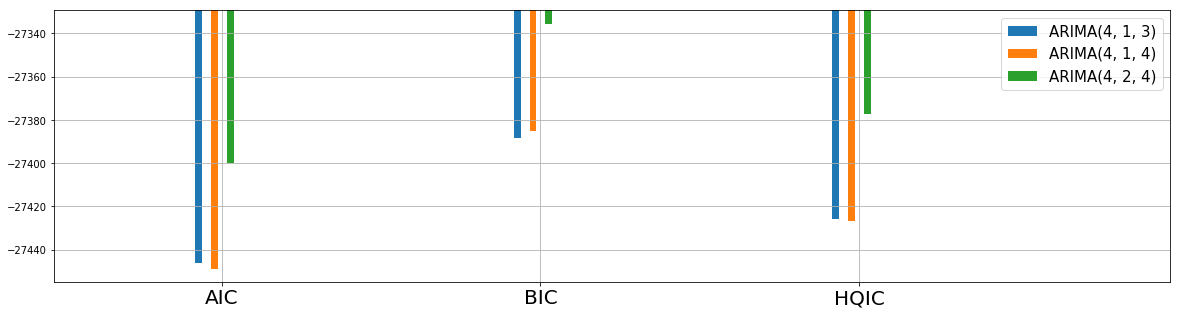

In [17]:
# model comparison
plt.figure(figsize=(20,5))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)

# set width of bar
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)-1)/2)*spacing

for i in np.arange(len(labels)-1):
    plt.bar(r, df_IC.loc[labels[i+1]].values, width=barWidth, edgecolor='white', label=labels[i+1])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

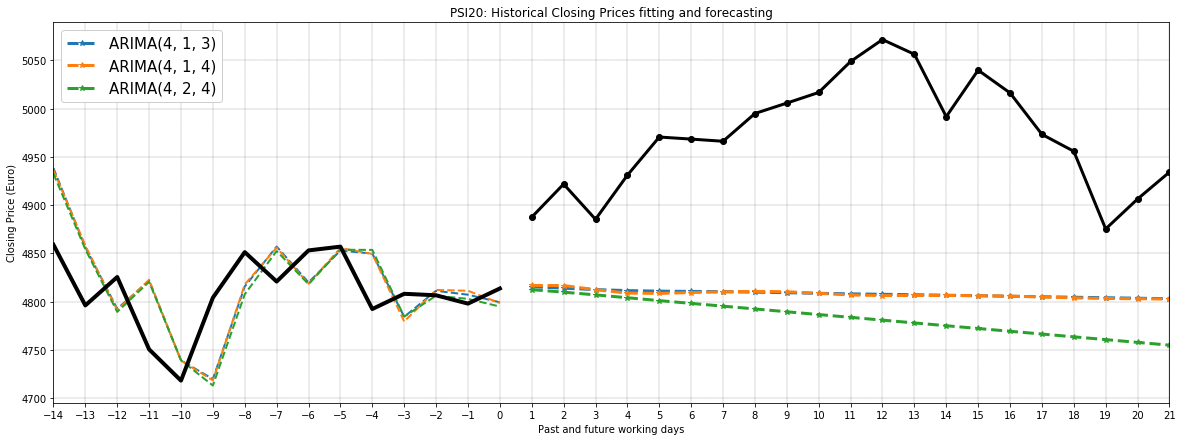

In [18]:
# plot results
plt.figure(figsize=(20,7))
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3 )
for i in np.arange(len(labels)-1):
    arimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_arimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_arimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=arimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 )
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future working days')
plt.ylabel(ylab);

In [19]:
for i in np.arange(len(labels)-1):
    print(labels[i+1])
    printMAEpred(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    print(" ")

ARIMA(4, 1, 3)
Prediction for 1 step: MAE = 72.03 (1.47%)
Prediction for 5 step: MAE = 106.38 (2.16%)
Prediction for 21 step: MAE = 163.93 (3.28%)
 
ARIMA(4, 1, 4)
Prediction for 1 step: MAE = 70.78 (1.45%)
Prediction for 5 step: MAE = 106.59 (2.16%)
Prediction for 21 step: MAE = 164.25 (3.29%)
 
ARIMA(4, 2, 4)
Prediction for 1 step: MAE = 75.09 (1.54%)
Prediction for 5 step: MAE = 112.35 (2.28%)
Prediction for 21 step: MAE = 188.48 (3.78%)
 


# Model Validation

In [36]:
# Pick you favourite's models order
order = (4, 1, 2)
model = ARIMA(df_Train.values, order=order)
model_fit = model.fit(disp=0);
df_res = pd.DataFrame({"resid": model_fit.resid}, index= df_Train.index[order[1]:])
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 6693
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -12155.692
Method:                       css-mle   S.D. of innovations              1.488
Date:                Sun, 19 Jan 2020   AIC                          24327.383
Time:                        20:05:41   BIC                          24381.854
Sample:                             1   HQIC                         24346.195
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.015      2.421      0.016       0.007       0.066
ar.L1.D.y      1.0956      0.439      2.496      0.013       0.235       1.956
ar.L2.D.y     -0.3843      0.358     -1.075      0.283      -1.085       0.317
ar.L3.D.y      0.0295      0.018      1.608      0.108      -0.006       0.065
ar.L4.D.y     -0.0392      0.015     -2.594      0.010      -0.069      -0.010
ma.L1.D.y     -1.1474      0.439     -2.613      0.009      -2.008      -0.287
ma.L2.D.y      0.3954      0.380      1.042      0.298      -0.349       1.139
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2803           -0.6503j            1.4360           -0.0748
AR.2            1.2803           +0.6503j            1.4360            0.0748
AR.3           -0.9044           -3.3997j            3.5180           -0.2914
AR.4           -0.9044           +3.3997j            3.5180            0.2914
MA.1            1.4508           -0.6512j            1.5902           -0.0671
MA.2            1.4508           +0.6512j            1.5902            0.0671
-----------------------------------------------------------------------------
"""

NameError: name 'dict_arimaFit' is not defined

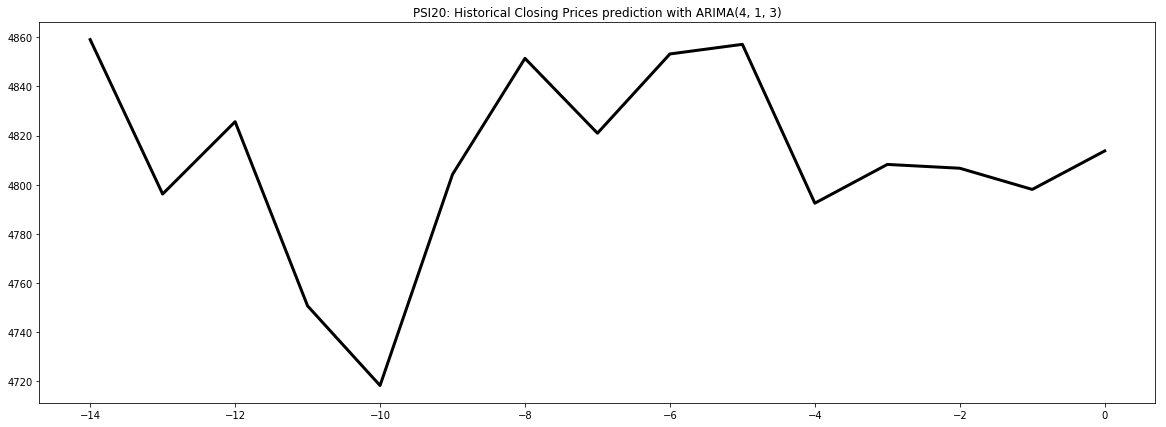

In [13]:
plt.figure(figsize=(20,7))
labels = ['Training and testing data', 'Fitted values', 'Predicted values']
plt.title(title + " prediction with ARIMA" + str(order))
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 3 )
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_arimaFit['ARIMA' + str(order)][-previousStepsToShow:], 'b--' , linewidth = 2)
plt.plot(1+np.arange(stepsToForecast[-1]), dict_arimaPred['ARIMA' + str(order)], 'r--*' , linewidth = 2)
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3 )
plt.legend(labels, loc='upper left')
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab)
plt.show()

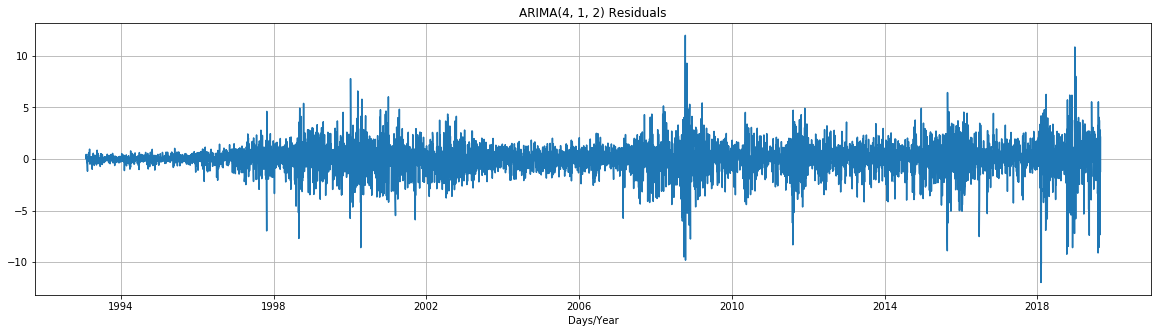

In [37]:
# Plot model residuals
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title('ARIMA' + str(order) +' Residuals')
plt.grid()

TypeError: unsupported operand type(s) for /: 'AxesSubplot' and 'int'

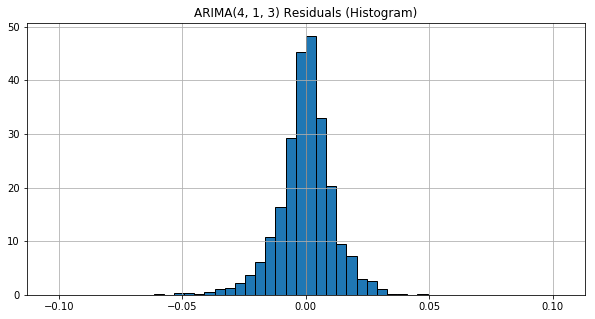

In [27]:
# Plot histogram
plt.figure(figsize=(10,5))
plt.title('ARIMA' + str(order) + ' Residuals (Histogram)')
hist_res = df_res['resid'].hist(bins=50, normed=1, edgecolor='black')

df_res['resid'].plot(kind='kde', linewidth=2, linestyle='--')
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.8, r'$\mu = $'+ str(round(np.mean(df_res), 6)))
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.75, r'$\sigma^2 = $' + str(round(np.var(df_res), 6)))
plt.xlabel('Residuals')
limX = np.mean(df_res.values)+5*np.std(df_res.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

In [ ]:
print ("Mean: %.6f" % np.mean(df_res))
print ("Variance: %.6f" % np.var(df_res))

### Normality Test

In [15]:
k, kpval = kurtosistest(df_res['resid'].values)
kurtosis_val = kurtosis(df_res['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)
print(" ")

s, spval = skewtest(df_res['resid'].values)
skew_val = skew(df_res['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 
print(" ")

jb, jbpval= stats.jarque_bera(df_res['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print(" ")

ks, kspval = stats.kstest(df_res['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Kurtosis Test
Statistic: 25.2073
p-value: 0.0000
Kurtosis value: 6.9436
 
Skew Test
Statistic: -5.5739
p-value: 0.0000
Skewness value: -0.2050
 
Jarque-Bera Test
Statistic: 9095.8044
p-value: 0.0000
 
Kolmogorov-Smirnov Test
Statistic: 0.4834
p-value: 0.0000


### Engle\'s Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [ ]:
lm, lmpval, fval, fpval = het_arch(df_res['resid'].values)
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')

print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

### Test for No Autocorrelation

#### Brock–Dechert–Scheinkman test

In [40]:
# Computing BDS
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df_res['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

BDS Test
Dim 2: z-static 18.2918 Prob 0.0000
Dim 3: z-static 26.3305 Prob 0.0000
Dim 4: z-static 31.2389 Prob 0.0000
Dim 5: z-static 35.4817 Prob 0.0000
Dim 6: z-static 39.2748 Prob 0.0000


#### Breusch-Godfrey test

In [14]:
lm, lmpval, fval, fpval = acorr_breusch_godfrey(model_fit, nlags = max(order[0], order[2]))
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')

print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

Lagrange multiplier test statistic
LM Statistic: -3.5899
LM-Test p-value: 1.0000

fstatistic for F test
F Statistic: 0.1111
F-Test p-value: 0.9787



#### Box-Pierce test

In [ ]:
maxLags = 21
lbvalue, pvalue, bpvalue, bppvalue = acorr_ljungbox(df_res['resid'].values, lags = range(1, maxLags), boxpierce=True)
df_boxpierce = pd.DataFrame({'lags':range(1, maxLags), 'bp statistic': bpvalue, 'p-value':bppvalue})
print(df_boxpierce[['lags', 'bp statistic', 'p-value']].to_string(index = False))

#### Ljung-Box test

In [ ]:
df_ljungbox = pd.DataFrame({'lags':range(1, maxLags), 'lb statistic': bpvalue, 'p-value':pvalue})
print(df_ljungbox[['lags', 'lb statistic', 'p-value']].to_string(index = False))

In [ ]:
qqplot(df_res['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()

In [ ]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));